## Loading Required Libraries

In [ ]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#importing libraries
import numpy as np
from scipy.io import savemat, loadmat
from skimage.measure import compare_ssim
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
 
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#disabling eager execution method in tensorflow
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
#installing library for adversarial learning
pip install adversarial-robustness-toolbox

     |████████████████████████████████| 890kB 9.1MB/s 
     |████████████████████████████████| 21.0MB 1.5MB/s 
     |████████████████████████████████| 235kB 54.9MB/s 
     |████████████████████████████████| 747kB 44.4MB/s 


In [ ]:
#loading adversarial learning libraries
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod
from art.defences.transformer.poisoning import NeuralCleanse

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Training a CNN Model for Image Classification on CIFAR10 Data

### Loading & Partioning CIFAR10 Data

In [ ]:
#downloading cifar10 data
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

170500096/170498071 [==============================] - 3s 0us/step
Train data shape:  (50000, 32, 32, 3) (50000, 1)
Test data shape:  (10000, 32, 32, 3) (10000, 1)


### Displaying Some Random Images from Data

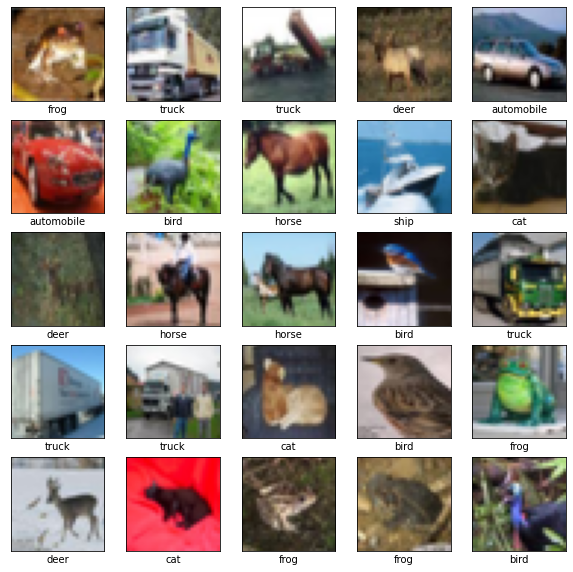

In [ ]:
#displaying sample images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

### Data Normalization

In [ ]:
#normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
#one hot encoding of label
y_train_cat = to_categorical(y_train,10)
y_test_cat = to_categorical(y_test,10)

### Model Callbacks

In [ ]:
#callbacks
earlystop = EarlyStopping(patience = 5, monitor = 'val_accuracy')
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1, 
                                            factor = 0.25, min_lr = 0.00001, restore_best_weights = True)
callbacks = [earlystop, learning_rate_reduction]

### Defining Model Structure

In [ ]:
#defining model structure
model = models.Sequential([
               layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
               layers.BatchNormalization(),
               layers.Conv2D(64, (3, 3), activation='relu', padding='same'), 
               layers.BatchNormalization(),
               layers.MaxPooling2D(2, 2),
               layers.Dropout(0.5),
    
               layers.Conv2D(96, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.Conv2D(96, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.MaxPooling2D(2, 2),
               layers.Dropout(0.5),
    
               layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.MaxPooling2D(2, 2), 
               layers.Dropout(0.5),
    
               layers.Flatten(),
    
               layers.Dense(256, activation='relu'),
               layers.BatchNormalization(),
               layers.Dropout(0.25),
    
               layers.Dense(192, activation='relu'),
               layers.BatchNormalization(),
               layers.Dropout(0.25),
    
               layers.Dense(128, activation='relu'),
               layers.BatchNormalization(),
               layers.Dropout(0.25),

               layers.Dense(10, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 96)        5

### Model Training

In [ ]:
#model fitting
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
 
epochs = 40
history = model.fit(X_train, y_train_cat, epochs = epochs, batch_size = 32, validation_split = 0.1, callbacks = callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/40
45000/45000 [==============================] - 30s 676us/sample - loss: 1.8160 - accuracy: 0.3518 - val_loss: 1.4537 - val_accuracy: 0.4842
Epoch 2/40
45000/45000 [==============================] - 29s 636us/sample - loss: 1.3074 - accuracy: 0.5322 - val_loss: 1.0479 - val_accuracy: 0.6166
Epoch 3/40
45000/45000 [==============================] - 29s 645us/sample - loss: 1.0898 - accuracy: 0.6172 - val_loss: 1.0387 - val_accuracy: 0.6396
Epoch 4/40
45000/45000 [==============================] - 29s 645us/sample - loss: 0.9631 - accuracy: 0.6665 - val_loss: 0.9895 - val_accuracy: 0.6498
Epoch 5/40
45000/45000 [==============================] - 29s 634us/sample - loss: 0.8804 - accuracy: 0.6977 - val_loss: 0.8776 - val_accuracy: 0.7028
Epoch 6/40
45000/45000 [==============================] - 29s 641us/sample - loss: 0.8110 - accuracy: 0.7198 - val_loss: 0.6879 - val_accuracy: 0.7604
Epoch 7/40
45000/45000 [=====================

### Training Performance wrt Epochs

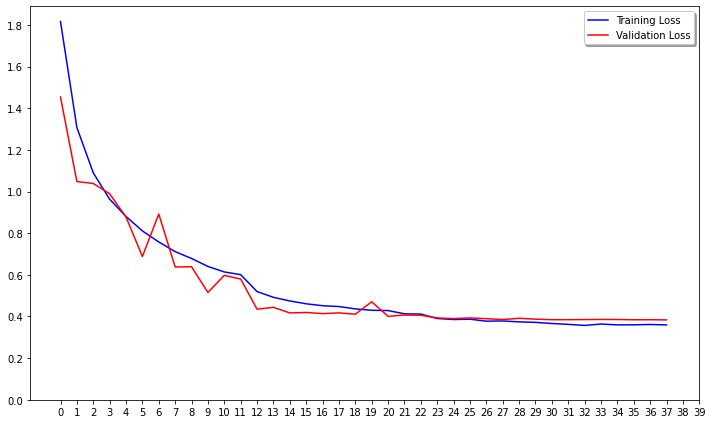

In [ ]:
#loss vs epoch plot
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax1.plot(history.history['loss'], color='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation Loss")
ax1.set_xticks(np.arange(0, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.2))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Model Performance on Train & Test Data

In [ ]:
#checking model performance on test data
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose = 2)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 0.39725835884809496
Test accuracy: 0.8688


In [ ]:
#class wise accuracy
y_test_pred = np.argmax(model.predict(X_test), axis = 1)
cm = confusion_matrix(y_test_pred, y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(np.array([[d, c] for d, c in zip(class_names, cm.diagonal())]))

[['airplane' '0.8702807357212003']
 ['automobile' '0.9459183673469388']
 ['bird' '0.8754448398576512']
 ['cat' '0.7995391705069125']
 ['deer' '0.8134057971014492']
 ['dog' '0.7992125984251969']
 ['frog' '0.8560953253895509']
 ['horse' '0.9065606361829026']
 ['ship' '0.9288577154308617']
 ['truck' '0.8925541941564562']]


## Adversarial Data Generation

### FGSM Attack

In [ ]:
#converting to art classifier
classifier = KerasClassifier(model = model, use_logits = False)

In [ ]:
#FGSM Attack
attack_fgsm = FastGradientMethod(classifier, eps = 0.1)

In [ ]:
X_train_adv_fgsm = attack_fgsm.generate(X_train)
X_test_adv_fgsm = attack_fgsm.generate(X_test)

#### Model Performance on FGSM Attacked Data

In [ ]:
#Performance for FGSM attack
test_loss, test_acc = model.evaluate(X_test_adv_fgsm, y_test_cat)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 5.614383654022217
Test accuracy: 0.1087


Accuracy dropped from 87% on normal images to 10% on FGSM attacked images

In [ ]:
#Mean perturbation of FGSM Attack
perturbation_test = np.mean(np.abs((X_test_adv_fgsm - X_test)))
print('Average perturbation on test: {:4.2f}'.format(perturbation_test))

Average perturbation on test: 0.10


In [ ]:
#Mean SSIM of FGSM Attack
ssim_fgsm = []
for i in range(len(X_test)):
         score = compare_ssim(X_test_adv_fgsm[i], X_test[i], full = True, multichannel = True)[0]
         ssim_fgsm.append(score)

print("SSIM: {}".format(mean(ssim_fgsm)))

SSIM: 0.700594661611947


In [ ]:
y_test_adv_fgsm = np.argmax(model.predict(X_test_adv_fgsm), axis = 1)

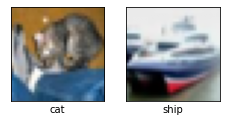

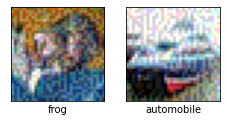

In [ ]:
plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_test[i][0]])
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.clip(X_test_adv_fgsm[i], 0, 1), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_test_adv_fgsm[i]])
plt.show()



FGSM attack is able to bypass the model, but image perturbation is visible

### Carline Wagner L-INF Attack

In [ ]:
#L-INF Attack
attack_linf = CarliniLInfMethod(classifier, eps = 0.2, max_iter = 50, learning_rate = 0.05)

In [ ]:
X_train_adv_linf = attack_linf.generate(X_train) 
X_test_adv_linf = attack_linf.generate(X_test) 




C&W L_inf:   0%|          | 0/391 [00:00<?, ?it/s]


C&W L_inf:   0%|          | 1/391 [00:17<1:52:58, 17.38s/it]


C&W L_inf:   1%|          | 2/391 [00:38<2:00:22, 18.57s/it]


C&W L_inf:   1%|          | 3/391 [01:02<2:09:51, 20.08s/it]


C&W L_inf:   1%|          | 4/391 [01:23<2:11:27, 20.38s/it]


C&W L_inf:   1%|▏         | 5/391 [01:44<2:12:09, 20.54s/it]


C&W L_inf:   2%|▏         | 6/391 [01:57<1:57:15, 18.27s/it]


C&W L_inf:   2%|▏         | 7/391 [02:20<2:05:27, 19.60s/it]


C&W L_inf:   2%|▏         | 8/391 [02:37<2:00:33, 18.89s/it]


C&W L_inf:   2%|▏         | 9/391 [02:55<1:59:16, 18.73s/it]


C&W L_inf:   3%|▎         | 10/391 [03:17<2:05:07, 19.71s/it]


C&W L_inf:   3%|▎         | 11/391 [03:35<2:01:13, 19.14s/it]


C&W L_inf:   3%|▎         | 12/391 [03:54<1:59:53, 18.98s/it]


C&W L_inf:   3%|▎         | 13/391 [04:12<1:58:44, 18.85s/it]


C&W L_inf:   4%|▎         | 14/391 [04:29<1:55:07, 18.32s/it]


C&W L_inf:   4%|▍         | 15/391 [04:56<2:10:09, 20.77s

#### Model Performance on L-INF Attacked Data

In [ ]:
#Performance for L-INF attack
test_loss, test_acc = model.evaluate(X_test_adv_linf, y_test_cat)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 2.3736551609039305
Test accuracy: 0.1696


Here also accuracy is dropping from 87% to 17%

In [ ]:
#Mean perturbation of L-INF Attack
perturbation_test = np.mean(np.abs((X_test_adv_linf - X_test)))
print('Average perturbation on test: {:4.2f}'.format(perturbation_test))

Average perturbation on test: 0.01


In [ ]:
#Mean SSIM of L-INF Attack
ssim_linf = []
for i in range(len(X_test)):
         score = compare_ssim(X_test_adv_linf[i], X_test[i], full = True, multichannel = True)[0]
         ssim_linf.append(score)

print("SSIM: {}".format(mean(ssim_linf)))

SSIM: 0.9560236850942453


In [ ]:
y_test_adv_linf = np.argmax(model.predict(X_test_adv_linf), axis = 1)

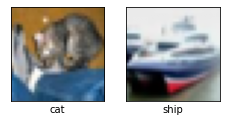

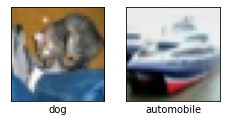

In [ ]:
plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_test[i][0]])
plt.show()

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_adv_linf[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_test_adv_linf[i]])
plt.show()



Image quality of L-INF attacked images are similar to normal images with hardly any difference visible to nacked eyes

### There are various ways to deal with adversarial attack:
1. Adversarial Detection Model to Identify & Drop Adversarial Samples
2. Adversarial Training for Orginal Task by Including Adversial Samples in Training Data

### ADVERSAIAL DETECTION
Identifying which sample is original and which is perturbated sample?

In [ ]:
#creating dataset - X
X_train_all = np.concatenate((X_train, X_train_adv_fgsm, X_train_adv_linf), axis = 0)
X_train_all.shape

(150000, 32, 32, 3)

In [ ]:
#creating labels
y_train_all = np.concatenate((np.zeros(50000), np.ones(100000)), axis = 0)
y_train_all.shape

(150000,)

In [ ]:
indices = np.arange(X_train_all.shape[0])
np.random.shuffle(indices)

X_train_all = X_train_all[indices]
y_train_all = y_train_all[indices]

In [ ]:
#sample weights
sample_weight = np.ones(shape=(len(X_train_all),))
sample_weight[0:50000] = 1
sample_weight[50000:100000] = 0.3
sample_weight[100000:150000] = 2.2
sample_weight = sample_weight[indices]

In [ ]:
#defining model structure
detection_model = models.Sequential([
               layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
               layers.BatchNormalization(),
    
               layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.MaxPooling2D(2, 2),
               layers.Dropout(0.5),
    
               layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.MaxPooling2D(2, 2), 
               layers.Dropout(0.5),

               layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.MaxPooling2D(2, 2), 
               layers.Dropout(0.5),

               layers.Flatten(),
    
               layers.Dense(128, activation='relu'),
               layers.BatchNormalization(),
               layers.Dropout(0.25),
    
               layers.Dense(64, activation='relu'),
               layers.BatchNormalization(),
               layers.Dropout(0.25),
    
               layers.Dense(32, activation='relu'),
               layers.BatchNormalization(),
               layers.Dropout(0.25),

               layers.Dense(1, activation='sigmoid')])

detection_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 128)       73856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 30, 128)       512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 30, 128)       512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 128)      

In [ ]:
#model fitting
detection_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
 
epochs = 40
history = detection_model.fit(X_train_all, y_train_all, epochs = epochs, batch_size = 32, sample_weight = sample_weight, validation_split = 0.3, callbacks = callbacks)

Train on 105000 samples, validate on 45000 samples
Epoch 1/40
105000/105000 [==============================] - 108s 1ms/sample - loss: 0.6582 - accuracy: 0.6665 - val_loss: 0.6035 - val_accuracy: 0.6737
Epoch 2/40
105000/105000 [==============================] - 103s 985us/sample - loss: 0.5796 - accuracy: 0.7083 - val_loss: 0.5861 - val_accuracy: 0.6752
Epoch 3/40
105000/105000 [==============================] - 105s 1ms/sample - loss: 0.5254 - accuracy: 0.7621 - val_loss: 0.4942 - val_accuracy: 0.8267
Epoch 4/40
105000/105000 [==============================] - 104s 986us/sample - loss: 0.4865 - accuracy: 0.7978 - val_loss: 0.4877 - val_accuracy: 0.8518
Epoch 5/40
105000/105000 [==============================] - 103s 982us/sample - loss: 0.4665 - accuracy: 0.8133 - val_loss: 0.4512 - val_accuracy: 0.8090
Epoch 6/40
105000/105000 [==============================] - 104s 991us/sample - loss: 0.4519 - accuracy: 0.8272 - val_loss: 0.4436 - val_accuracy: 0.8648
Epoch 7/40
105000/105000 [===

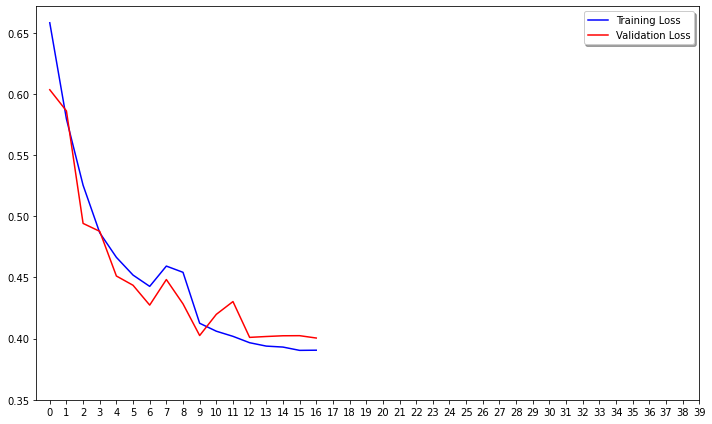

In [ ]:
#loss vs epoch plot
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax1.plot(history.history['loss'], color='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation Loss")
ax1.set_xticks(np.arange(0, epochs, 1))
ax1.set_yticks(np.arange(0.35, 0.7, 0.05))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
#checking model performance on un-attacked original test data
test_loss, test_acc = detection_model.evaluate(X_test, np.zeros(len(X_test)), verbose = 2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.4906580910682678
Test accuracy: 0.8674


In [ ]:
#checking model performance on FGSM attacked data
test_loss, test_acc = detection_model.evaluate(X_test_adv_fgsm, np.ones(len(X_test_adv_fgsm)), verbose = 2)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 0.002339512383565307
Test accuracy: 1.0


In [ ]:
#checking model performance on L-INF attacked data
test_loss, test_acc = detection_model.evaluate(X_test_adv_linf, np.ones(len(X_test_adv_fgsm)), verbose = 2)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 0.3761338299751282
Test accuracy: 0.7146


Detection Model is able to identify all FGSM attacked sample, whereas it's accuracy is considerable on lower side at 71% for L-INF attacked samples

### Adversarial Training

In [ ]:
#creating dataset - X
X_train_def = np.concatenate((X_train, X_train_adv_fgsm, X_train_adv_linf), axis = 0)
X_train_def.shape

(150000, 32, 32, 3)

In [ ]:
del X_train, X_train_adv_fgsm, X_train_adv_linf

In [ ]:
#Creating label
y_train_def = np.concatenate((y_train, y_train, y_train), axis = 0)
y_train_def.shape

(150000, 1)

In [ ]:
#one hot encoding of label
y_train_def_cat = to_categorical(y_train_def, 10)

In [ ]:
indices = np.arange(X_train_def.shape[0])
np.random.shuffle(indices)

X_train_def = X_train_def[indices]
y_train_def_cat = y_train_def_cat[indices]

In [ ]:
sample_weight = np.ones(shape=(len(X_train_def),))
sample_weight[0:50000] = 1
sample_weight[50000:100000] = 0.8
sample_weight[100000:150000] = 1.2
sample_weight = sample_weight[indices]

In [ ]:
#defining model structure
def_model = models.Sequential([
               layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
               layers.BatchNormalization(),
               layers.GaussianNoise(0.05),
               layers.Dropout(0.25),
    
               layers.Conv2D(96, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.GaussianNoise(0.05),
               layers.Conv2D(96, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.GaussianNoise(0.05),
               layers.MaxPooling2D(2, 2),
               layers.Dropout(0.5),
    
               layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.GaussianNoise(0.05),
               layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.GaussianNoise(0.05),
               layers.MaxPooling2D(2, 2), 
               layers.Dropout(0.5),

               layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
               layers.BatchNormalization(),
               layers.GaussianNoise(0.05),
               layers.MaxPooling2D(2, 2), 
               layers.Dropout(0.5),
    
               layers.Flatten(),
    
               layers.Dense(256, activation='relu'),
               layers.BatchNormalization(),
               layers.GaussianNoise(0.05),
               layers.Dropout(0.5),
    
               layers.Dense(128, activation='relu'),
               layers.BatchNormalization(),
               layers.GaussianNoise(0.05),
               layers.Dropout(0.5),
    
               layers.Dense(64, activation='relu'),
               layers.BatchNormalization(),
               layers.GaussianNoise(0.05),
               layers.Dropout(0.5),

               layers.Dense(10, activation='softmax')])

def_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 96)        55392     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 30, 30, 96)        0

In [ ]:
#model fitting
def_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
 
epochs = 20
history = def_model.fit(X_train_def, y_train_def_cat, epochs = epochs, batch_size = 32, sample_weight = sample_weight)

Train on 150000 samples
Epoch 1/20
150000/150000 [==============================] - 153s 1ms/sample - loss: 1.7171 - accuracy: 0.3794
Epoch 2/20
150000/150000 [==============================] - 146s 974us/sample - loss: 1.3151 - accuracy: 0.5342
Epoch 3/20
150000/150000 [==============================] - 144s 959us/sample - loss: 1.1399 - accuracy: 0.6089
Epoch 4/20
150000/150000 [==============================] - 145s 966us/sample - loss: 1.0119 - accuracy: 0.6610
Epoch 5/20
150000/150000 [==============================] - 141s 943us/sample - loss: 0.9244 - accuracy: 0.6950
Epoch 6/20
150000/150000 [==============================] - 140s 930us/sample - loss: 0.8619 - accuracy: 0.7216
Epoch 7/20
150000/150000 [==============================] - 139s 928us/sample - loss: 0.8141 - accuracy: 0.7383
Epoch 8/20
150000/150000 [==============================] - 140s 932us/sample - loss: 0.7731 - accuracy: 0.7532
Epoch 9/20
150000/150000 [==============================] - 139s 930us/sample - lo

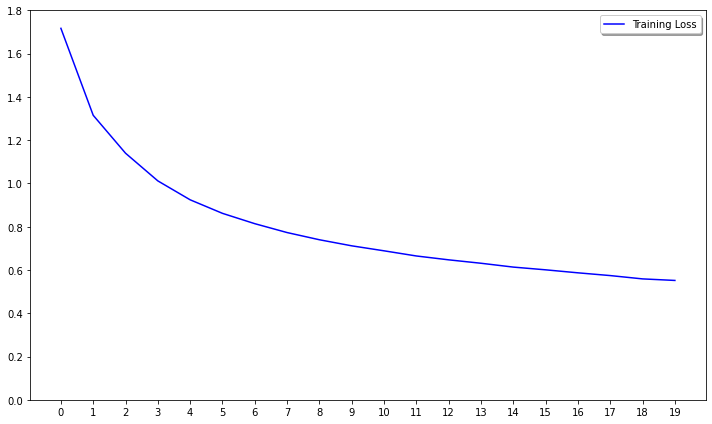

In [ ]:
#loss vs epoch plot
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax1.plot(history.history['loss'], color='b', label="Training Loss")
ax1.set_xticks(np.arange(0, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.2))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
#checking model performance on test data
test_loss, test_acc = def_model.evaluate(X_test, y_test_cat, verbose = 2)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 0.4779711462497711
Test accuracy: 0.8435


In [ ]:
#Performance for FGSM attack
test_loss, test_acc = def_model.evaluate(X_test_adv_fgsm, y_test_cat)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 0.607557222366333
Test accuracy: 0.8443


In [ ]:
#Performance for L-INF attack
test_loss, test_acc = def_model.evaluate(X_test_adv_linf , y_test_cat)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 0.4904614140510559
Test accuracy: 0.839


Using adversarial Training we are able to bring the accuracy to 84% which is juslt slightly less than 87% accuracy of original model

### Adversarial Detection & Drop Methodology on Unseen Data

Out of these 10k images, 5k are clean while rest 5k are perturbed/attacked images. We don't know which one is clean and which one is attacked.

In [ ]:
#loading dataset
data = loadmat(F"/content/gdrive/My Drive/DAI_Assignment2/testset.mat")
X = data['images']
y = data['labels']

X.shape

(10000, 32, 32, 3)

In [ ]:
#checking base model performance on given data
test_loss, test_acc = model.evaluate(X, y, verbose = 2)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 14.000681404793262
Test accuracy: 0.5742


In [ ]:
#attack detection using detection model from Question 1
detect = detection_model.predict_classes(X)

In [ ]:
#removing attacked/adversarial samples
index = np.where(detect == 0)[0]
Xn = X[index]
yn = y[index]

Xn.shape

(4332, 32, 32, 3)

In [ ]:
#checking base model performance on clean images
test_loss, test_acc = model.evaluate(Xn, yn, verbose = 2)
print('Test loss:', test_loss) 
print('Test accuracy:', test_acc)

Test loss: 0.37738528415657036
Test accuracy: 0.872807


Out of total 10k images, 5k are original while rest 5k are perturbed images. Detection model classifies 4332 as clean sample and makes a mistake in 668+ images. So actual model accuracy on these samples will not be87%, but 70-80% approx given mistakes in detection phase. This is also comparativel higher than 57%.